# Proyecto Est. Multivariada (CNN)

In [3]:
#Acceder a Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Importar librerías

In [1]:
import tensorflow as tf 
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(tf. __version__)

2.10.0


In [3]:
#Directorio de trabajo
#new_base_dir=r"/content/drive/MyDrive/PetImages/cats_vs_dogs_small"
# new_base_dir=r"/content/drive/MyDrive/human_detection_dataset"
new_base_dir=r"./human_detection_dataset"

Convierte la información de la imagen de píxeles en un tensor numérico de punto flotante y ajusta el tamaño de la imagen porque todas tienen diferente resolución.

Ajustando los datos para que todas las imágenes tengan la misma resolución y se procesen en lotes de 32 por cada pasada del algoritmo descenso de gradiente

In [4]:
#Importar datos
train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 307 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 306 files belonging to 2 classes.
Found 308 files belonging to 2 classes.


2022-11-16 19:41:26.903533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 19:41:26.903821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Visualizar el tensor asociado a los datos y las etiquetas

In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### Métricas a usar

Se usará Accuracy, Recall, Precision y F1-score

In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Modelo CNN - Sin regulariazción - Sin Data Augmentation
Definición de la red neuronal convolucional con n capas para imagénes de 180x180 píxeles. Hiperparámetros para el entrenamiento y medición de desempeño

Arquitectura de la red neuronal y definición del algoritmo de descenso de gradiente, función de pérdida y métrica de evaluación

In [6]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy",f1_m,precision_m, recall_m])

#Resumen modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Fase de entrenamiento

In [ ]:
history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset)

Visualización de la pérdida y el accuracy tanto para los datos de entrenamiento como para los datos de validación y así detectar si hay overfitting

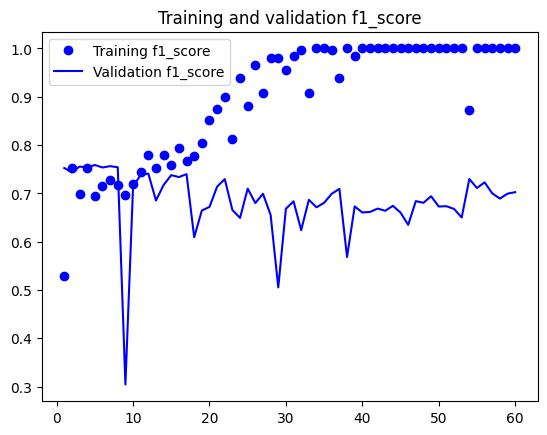

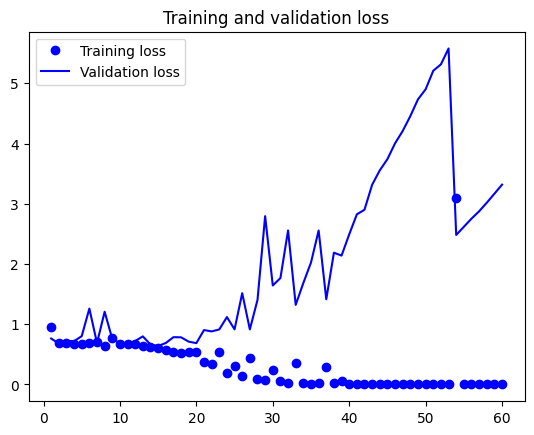

In [8]:
# accuracy = history.history["accuracy"]
# val_accuracy = history.history["val_accuracy"]
f1_score = history.history["f1_m"]
val_f1_score = history.history["val_f1_m"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(f1_score) + 1)
plt.plot(epochs, f1_score, "bo", label="Training f1_score")
plt.plot(epochs, val_f1_score, "b", label="Validation f1_score")
plt.title("Training and validation f1_score")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Verificación del accuracy en el test

In [9]:
test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
print('test_loss: ',test_loss)
print('test_acc: ',test_acc)
print('test_f1_score ',test_f1_score)
print('test_precision: ',test_precision)
print('test_recall: ',test_recall)

2022-11-16 17:57:42.073233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.132163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.151563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.159118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.171107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.185145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.256852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.339206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 17:57:42.502375: W tensorflow/core/lib/png/png_io.cc:88] PNG 

10/10 [==============================] - 2s 71ms/step - loss: 3.2717 - accuracy: 0.5974 - f1_m: 0.6862 - precision_m: 0.6462 - recall_m: 0.7506
test_loss:  3.271728277206421
test_acc:  0.5974025726318359
test_f1_score  0.6862083673477173
test_precision:  0.646169126033783
test_recall:  0.7506234049797058


In [ ]:
def grid_epochs(model, v_epochs, x_train, val_train, x_test, 
                y_train=None, y_test=None):
  #Inicializar variables para realizar proceso
  v_test_loss = []
  v_test_acc = []
  v_test_f1_score = []
  v_test_precision = []
  v_test_recall = []

  candidate_history = []

  #Iterar v_epochs evaluando f1_score
  for ep in v_epochs:
    history = model.fit(x_train, y_train, epochs=ep,
                        validation_data=val_train, verbose=0)
    candidate_history.append(history)

    test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(x_test, y_test)
    v_test_loss.append(test_loss)
    v_test_acc.append(test_acc)
    v_test_f1_score.append(test_f1_score)
    v_test_precision.append(test_precision)
    v_test_recall.append(test_recall)

  #Como arreglo
  v_test_loss = np.array(v_test_loss)
  v_test_acc = np.array(v_test_acc)
  v_test_f1_score = np.array(v_test_f1_score)
  v_test_precision = np.array(v_test_precision)
  v_test_recall = np.array(v_test_recall)

  #Gráficar f1_score vs epocas
  plt.figure()
  plt.plot(v_epochs, v_test_f1_score, marker='o', label="f1_score", color="blue")
  plt.title("f1_score vs epochs")
  plt.legend()
  plt.show()

  #Mejor resultado
  loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

  #training vs validation con mejor resultado
  best_history = candidate_history[loc_best_result]

  acc = best_history.history["accuracy"]
  val_acc = best_history.history["val_accuracy"]
  loss = best_history.history["loss"]
  val_loss = best_history.history["val_loss"]
  epochs = range(1, len(acc) + 1)

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
  ax1.plot(epochs, acc, "bo", label="Training accuracy")
  ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
  ax1.set_title("Training and validation accuracy")
  ax1.legend()
  ax2.plot(epochs, loss, "bo", label="Training loss")
  ax2.plot(epochs, val_loss, "b", label="Validation loss")
  ax2.set_title("Training and validation loss")
  ax2.legend()
  plt.show()

  print("Mejores resultados: con %.0f epocas " % v_epochs[loc_best_result])
  print("test_loss: %.4f" % v_test_loss[loc_best_result])
  print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
  print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
  print("test_precision: %.4f" % v_test_precision[loc_best_result])
  print("test_recall: %.4f" % v_test_recall[loc_best_result])

  return v_epochs[loc_best_result]

In [11]:
# history = best_model_history
v_epochs = [10, 15, 20, 30]
best_epoch = grid_epochs(model=model, v_epochs=v_epochs, 
                         x_train=train_features, y_train=train_labels,
                         val_train=(val_features, val_labels), 
                         x_test=test_features, y_test=test_labels)

## Modelo CNN - Con regulariazción - Sin Data Augmentation


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy",f1_m,precision_m, recall_m])

#Resumen modelo
model.summary()

## Modelo CNN - Con regulariazción - Con Data Augmentation


Transformaciones que se aplicarán a las imágenes: Desplazamiento aleatorio X, rotación aleatoria de máximo Y radianes y una reducción de máximo Z.

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.5),
    ]
)

Visualización de una imagen con todas las combinaciones de las tres transformaciones definidas, a saber: desplazamiento X, rotacion de Y radianes y Zoom de Z.

2022-11-16 17:30:56.345269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:30:57.105742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:30:57.814124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:30:58.375569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:30:59.129944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:30:59.708860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:00.397583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:01.047951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:01.729023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:02.290380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:03.034701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:03.603712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:04.260619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:04.896728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:05.562111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:06.146859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:06.903815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-16 17:31:07.588892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


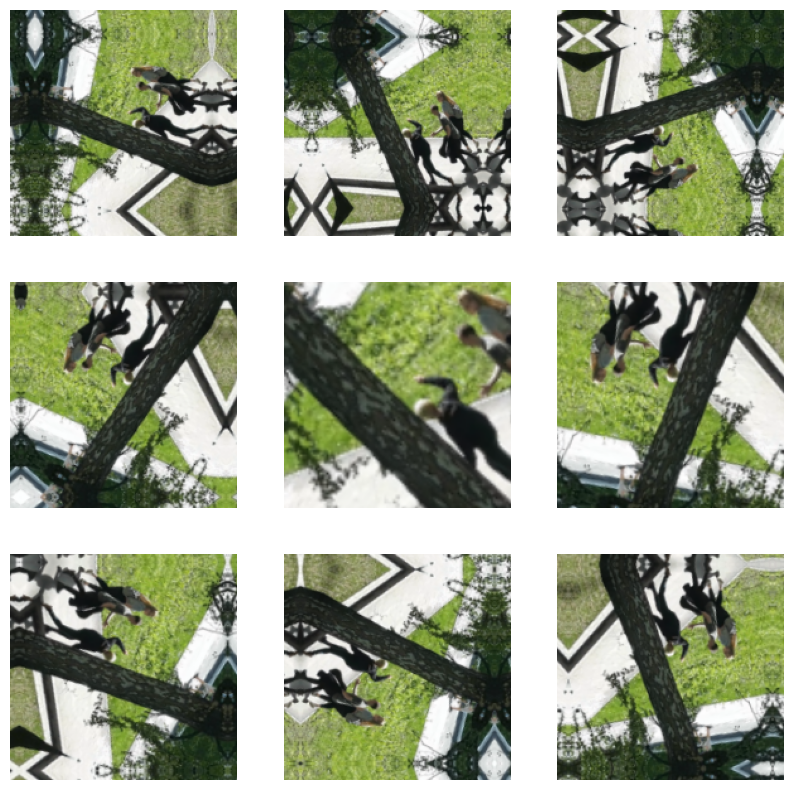

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Definición de la red neuronal convolucional con n capas para imagénes de 180x180 píxeles. Hiperparámetros para el entrenamiento y medición de desempeño

Arquitectura de la red neuronal y definición del algoritmo de descenso de gradiente, función de pérdida y métrica de evaluación

In [8]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [9]:
#Resumen modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

Fase de entrenamiento

In [ ]:
history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset)

Visualización de la pérdidad y el accuracy tanto para los datos de entrenamiento como para los datos de validación y así detectar si hay overfitting

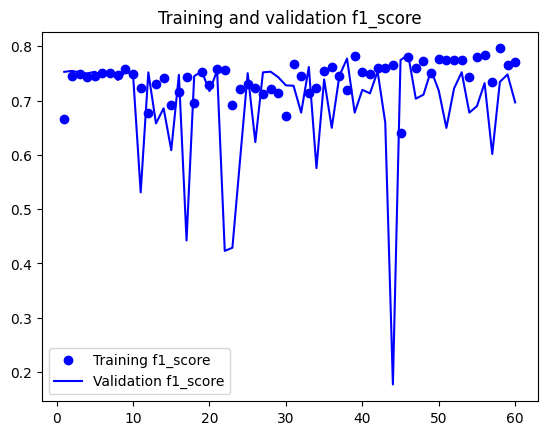

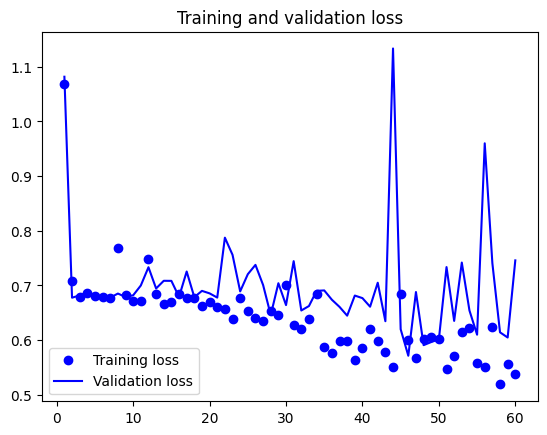

In [10]:
# accuracy = history.history["accuracy"]
# val_accuracy = history.history["val_accuracy"]
f1_score = history.history["f1_m"]
val_f1_score = history.history["val_f1_m"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(f1_score) + 1)
plt.plot(epochs, f1_score, "bo", label="Training f1_score")
plt.plot(epochs, val_f1_score, "b", label="Validation f1_score")
plt.title("Training and validation f1_score")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Verificación del accuracy en el test

In [11]:
test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
print('test_loss: ',test_loss)
print('test_acc: ',test_acc)
print('test_f1_score ',test_f1_score)
print('test_precision: ',test_precision)
print('test_recall: ',test_recall)

2022-11-16 03:16:22.701399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:22.769443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:22.820689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:22.938698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:23.006592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:23.073065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:23.127604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:23.184356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:16:23.188511: W tensorflow/core/lib/png/png_io.cc:88] PNG 

10/10 [==============================] - 3s 105ms/step - loss: 1.0729 - accuracy: 0.6364 - f1_m: 0.6998 - precision_m: 0.7010 - recall_m: 0.7033
test_loss:  1.0728789567947388
test_acc:  0.6363636255264282
test_f1_score  0.6997923254966736
test_precision:  0.7010326385498047
test_recall:  0.7032992243766785


In [ ]:
# # save the model to disk
# print("[INFO] serializing network...")
# # model.save(args["model"], save_format="h5")
# model.save('pedestrian1.model', save_format="h5")
# # save the label binarizer to disk
# print("[INFO] serializing label binarizer...")
# # f = open(args["labelbin"], "wb")
# f = open('lb.pickle', "wb")
# f.write(pickle.dumps(lb))
# f.close()

In [15]:
def grid_dropout(v_dropout):
  # , x_train, val_train, x_test, 
  #               y_train=None, y_test=None):
  #Inicializar variables para realizar proceso
  v_test_loss = []
  v_test_acc = []
  v_test_f1_score = []
  v_test_precision = []
  v_test_recall = []

  candidate_history = []

  #Iterar v_dropout evaluando f1_score
  for drpout in v_dropout:
    # history = model.fit(x_train, y_train, epochs=ep,
    #                     validation_data=val_train, verbose=0)
    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(drpout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss="binary_crossentropy",
                  optimizer="rmsprop",
                  metrics=["accuracy",f1_m,precision_m, recall_m])
    history = model.fit(
      train_dataset,
      epochs=20,
      validation_data=validation_dataset, verbose=0)
    candidate_history.append(history)

    test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
    # test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(x_test, y_test)
    v_test_loss.append(test_loss)
    v_test_acc.append(test_acc)
    v_test_f1_score.append(test_f1_score)
    v_test_precision.append(test_precision)
    v_test_recall.append(test_recall)

  #Como arreglo
  v_test_loss = np.array(v_test_loss)
  v_test_acc = np.array(v_test_acc)
  v_test_f1_score = np.array(v_test_f1_score)
  v_test_precision = np.array(v_test_precision)
  v_test_recall = np.array(v_test_recall)

  #Gráficar f1_score vs dropout
  plt.figure()
  plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
  plt.title("f1_score vs dropout")
  plt.legend()
  plt.show()

  #Mejor resultado
  loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

  #training vs validation con mejor resultado
  best_history = candidate_history[loc_best_result]

  print('best_history.history.keys()')
  print(best_history.history.keys())

  acc = best_history.history["f1_m"]
  val_acc = best_history.history["val_f1_m"]
  loss = best_history.history["loss"]
  val_loss = best_history.history["val_loss"]
  epochs = range(1, len(acc) + 1)

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
  ax1.plot(epochs, acc, "bo", label="Training f1_score")
  ax1.plot(epochs, val_acc, "b", label="Validation f1_score")
  ax1.set_title("Training and validation f1_score")
  ax1.legend()
  ax2.plot(epochs, loss, "bo", label="Training loss")
  ax2.plot(epochs, val_loss, "b", label="Validation loss")
  ax2.set_title("Training and validation loss")
  ax2.legend()
  plt.show()

  print("Mejores resultados: con %.2f dropout " % v_dropout[loc_best_result])
  print("test_loss: %.4f" % v_test_loss[loc_best_result])
  print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
  print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
  print("test_precision: %.4f" % v_test_precision[loc_best_result])
  print("test_recall: %.4f" % v_test_recall[loc_best_result])

  return v_dropout[loc_best_result]

2022-11-16 03:45:50.029112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 03:45:59.054412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 03:45:59.120947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:45:59.153296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:45:59.157594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:45:59.170534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:45:59.260375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:45:59.267538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB pr

 1/10 [==>...........................] - ETA: 8s - loss: 0.6693 - accuracy: 0.6562 - f1_m: 0.7925 - precision_m: 0.6774 - recall_m: 0.9545

2022-11-16 03:48:05.439382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.445629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.446034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.454088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.461925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.469289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.474721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.539110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:05.617965: W tensorflow/core/lib/png/png_io.cc:88] PNG 

10/10 [==============================] - 2s 163ms/step - loss: 0.7121 - accuracy: 0.5812 - f1_m: 0.7301 - precision_m: 0.5992 - recall_m: 0.9505


2022-11-16 03:48:10.026474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 03:48:18.990032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 03:48:19.050587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:19.078701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:19.081125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:19.090940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:19.172329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 03:48:19.178365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB pr

10/10 [==============================] - 6s 277ms/step - loss: 0.7080 - accuracy: 0.5617 - f1_m: 0.7144 - precision_m: 0.5949 - recall_m: 0.9109


2022-11-16 08:16:27.216135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 08:16:40.862907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 08:16:40.928228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:16:40.956449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:16:40.962726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:16:40.974219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:16:41.063240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:16:41.069627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB pr

 1/10 [==>...........................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6875 - f1_m: 0.8077 - precision_m: 0.7000 - recall_m: 0.9545

2022-11-16 08:19:26.661864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.669010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.669200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.673417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.682822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.695373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.700290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.773029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:26.853964: W tensorflow/core/lib/png/png_io.cc:88] PNG 

10/10 [==============================] - 2s 153ms/step - loss: 0.7121 - accuracy: 0.5942 - f1_m: 0.7404 - precision_m: 0.6069 - recall_m: 0.9689


2022-11-16 08:19:31.128096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 08:19:45.412399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 08:19:45.484470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:45.521508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:45.528798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:45.543114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:45.651657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:19:45.658694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB pr

 1/10 [==>...........................] - ETA: 14s - loss: 0.8060 - accuracy: 0.6875 - f1_m: 0.8148 - precision_m: 0.6875 - recall_m: 1.0000

2022-11-16 08:22:30.754316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-16 08:22:30.754623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/10 [==============================] - 3s 172ms/step - loss: 0.8718 - accuracy: 0.5779 - f1_m: 0.7211 - precision_m: 0.5925 - recall_m: 0.9342


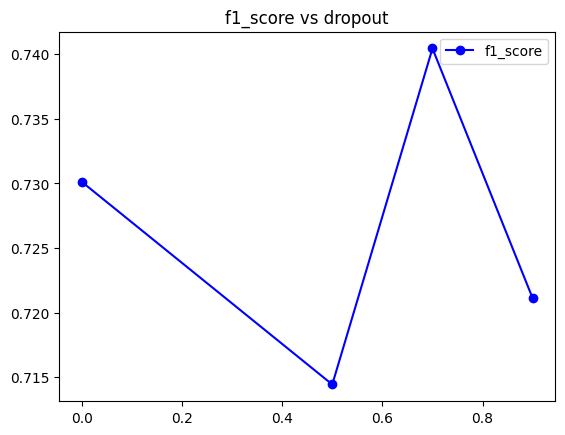

best_history.history.keys()
dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


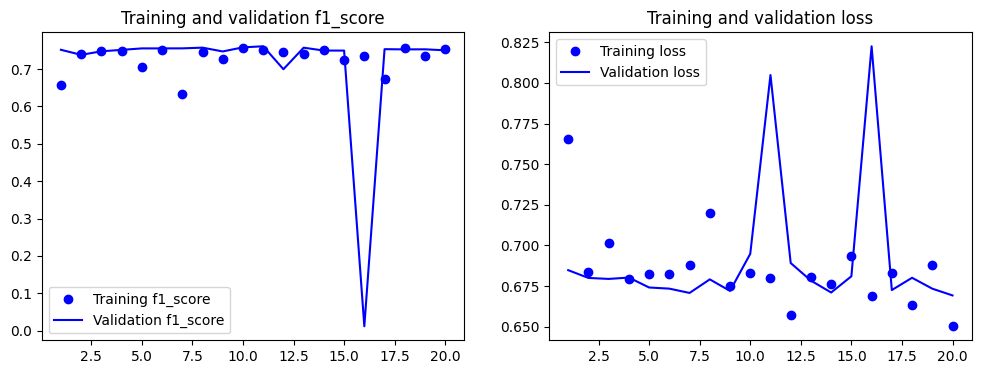

Mejores resultados: con 0.70 dropout 
test_loss: 0.7121
test_accuracy: 0.5942
test_f1_score: 0.7404
test_precision: 0.6069
test_recall: 0.9689


In [16]:
v_dropout = [0, 0.5, 0.7, 0.9]
best_epoch = grid_dropout(v_dropout=v_dropout) # , 
                        #  x_train=train_features, y_train=train_labels,
                        #  val_train=(val_features, val_labels), 
                        #  x_test=test_features, y_test=test_labels)
